In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import plot_importance, plot_tree

import warnings
warnings.filterwarnings('ignore')

set_config(display='diagram')

C:\Users\chipm\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_parquet('./Data/Tifton_SPI_FE.parquet')

In [3]:
color_pal = sns.color_palette()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3132 entries, 2008-11-01 to 2017-12-01
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   prcp_accum      3132 non-null   float64       
 1   air_temp_avg    3132 non-null   float64       
 2   smp_2           3132 non-null   float64       
 3   smp_4           3132 non-null   float64       
 4   smp_8           3132 non-null   float64       
 5   smp_20          3132 non-null   float64       
 6   smp_40          3132 non-null   float64       
 7   soil_temp_2     3132 non-null   float64       
 8   soil_temp_4     3132 non-null   float64       
 9   soil_temp_8     3132 non-null   float64       
 10  soil_temp_20    3132 non-null   float64       
 11  soil_temp_40    3132 non-null   float64       
 12  wind_dir_avg    3132 non-null   float64       
 13  wind_speed_avg  3132 non-null   float64       
 14  PRCP            3132 non-null   float6

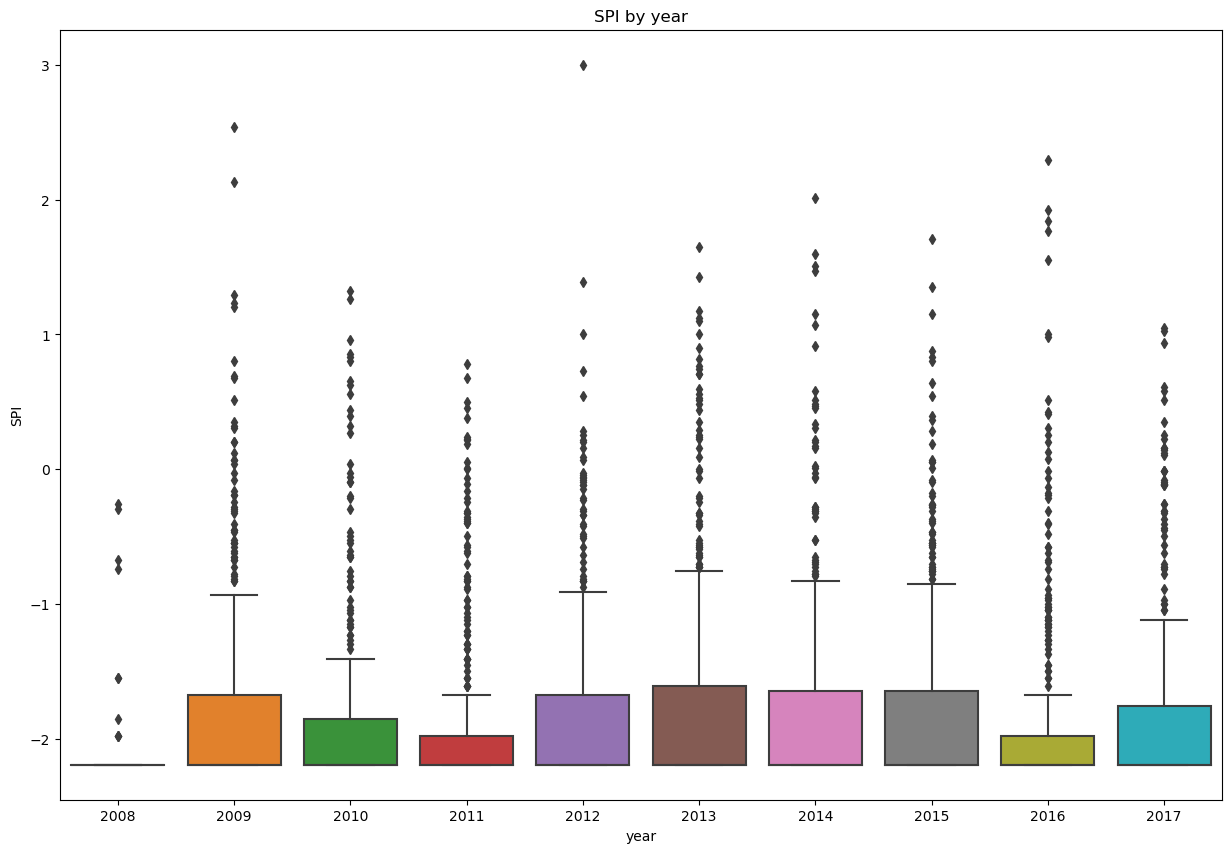

In [5]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=df, x='year', y='SPI')
ax.set_title('SPI by year')
plt.show()

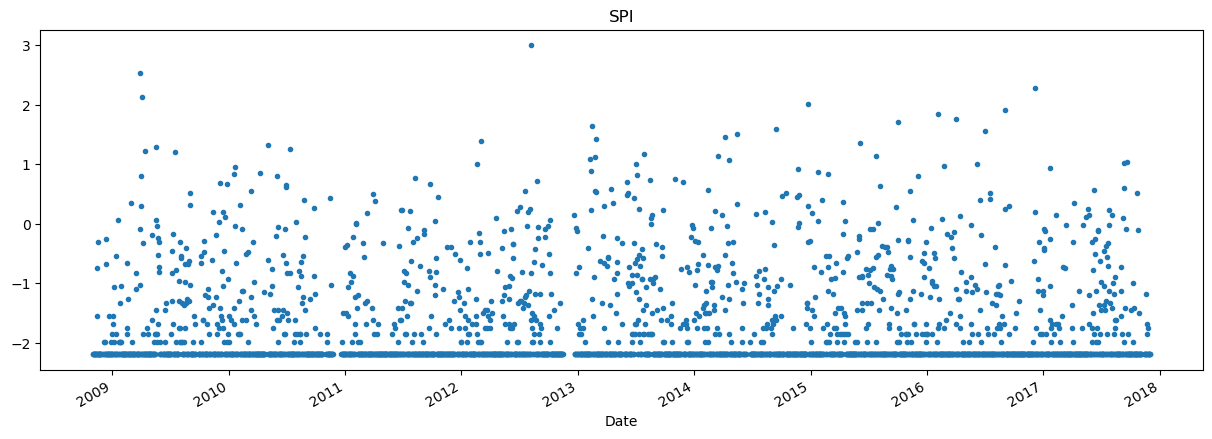

In [6]:
df.SPI.plot(style='.',
            figsize=(15, 5),
            color=color_pal[0],
            title="SPI"
            )
plt.show()

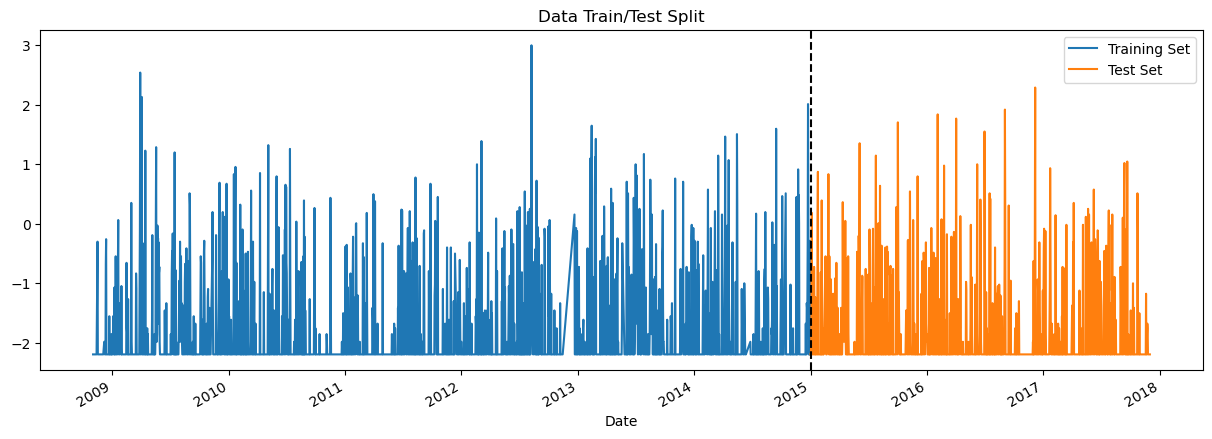

In [7]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']
fig, ax = plt.subplots(figsize=(15, 5))
train.SPI.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.SPI.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

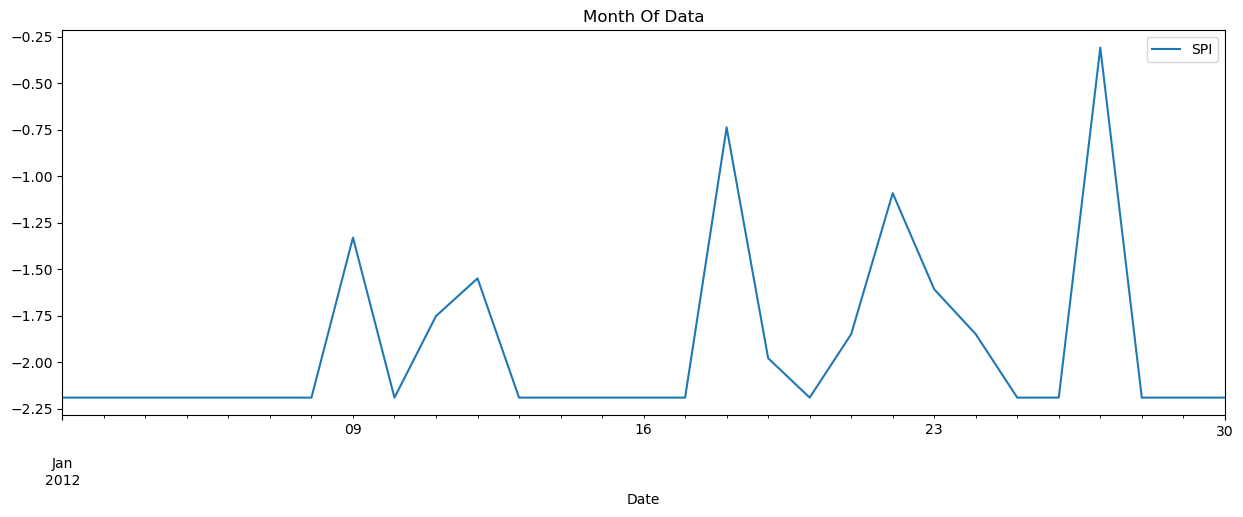

In [8]:
df[['SPI']].loc[(df.index > '01-01-2012') & (df.index < '01-31-2012')].plot(figsize=(15, 5), title='Month Of Data')
plt.show()

In [9]:
df = df.drop(['hour'], axis=1)

## Outlier Analysis

<AxesSubplot:ylabel='Frequency'>

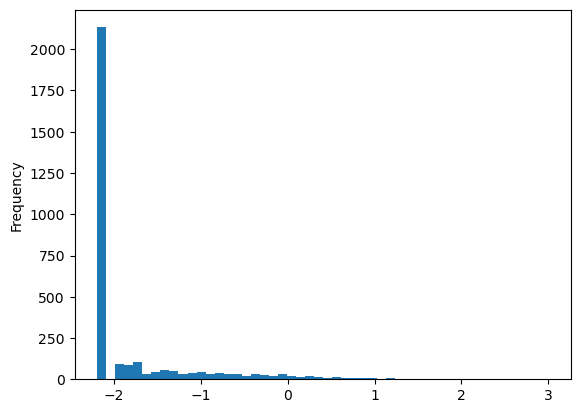

In [10]:
df['SPI'].plot(kind='hist', bins=50)

<AxesSubplot:title={'center':'Outliers'}, xlabel='Date'>

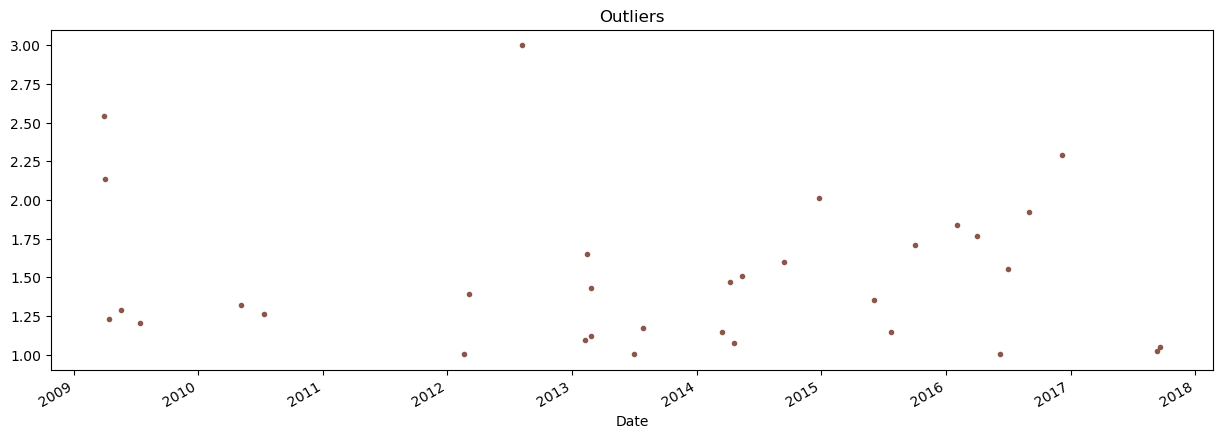

In [11]:
df.query('SPI > 1')['SPI'].plot(style='.',
                                figsize=(15, 5),
                                color=color_pal[5],
                                title='Outliers')

## Time series cross validation

In [12]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, gap=24)
df = df.sort_index()


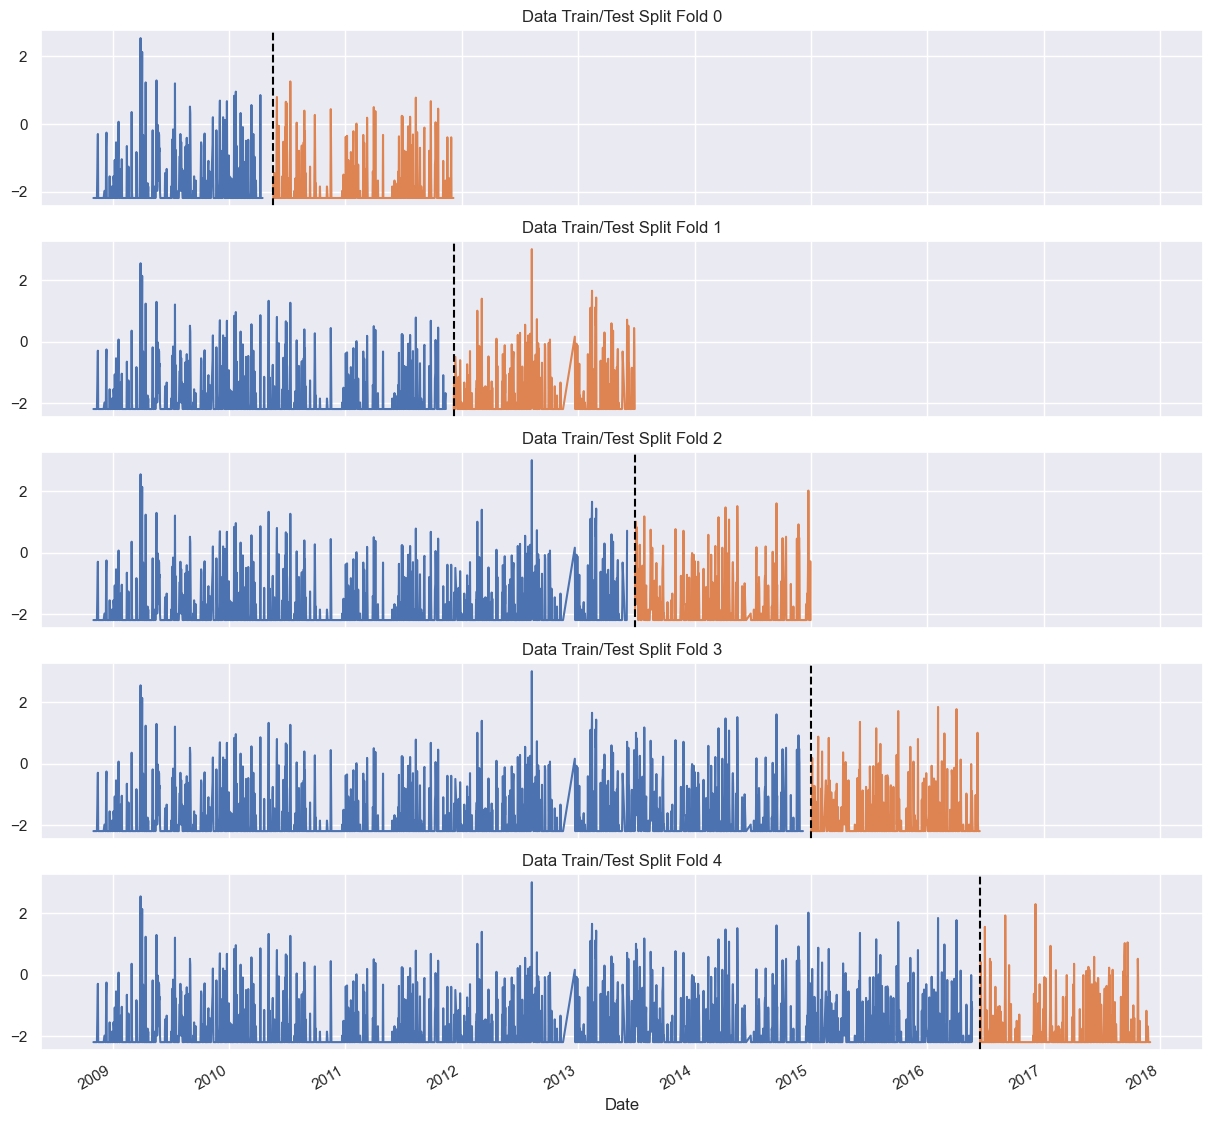

In [45]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['SPI'].plot(ax=axs[fold],
                      label='Training Set',
                      title=f'Data Train/Test Split Fold {fold}')
    test['SPI'].plot(ax=axs[fold],
                     label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [14]:

def add_lags(df):
    target_map = df['SPI'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [15]:
df = add_lags(df)

In [16]:
df.head(1).transpose()

Date,2008-11-01
prcp_accum,4.9
air_temp_avg,12.0
smp_2,8.8
smp_4,8.5
smp_8,11.0
smp_20,12.3
smp_40,24.0
soil_temp_2,13.8
soil_temp_4,14.3
soil_temp_8,15.7


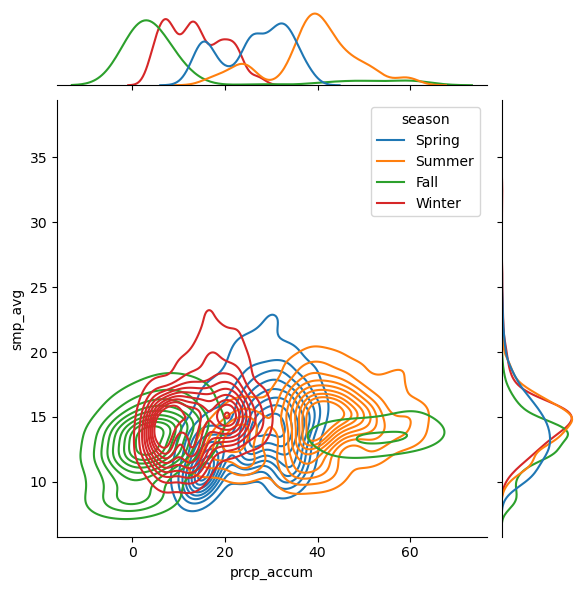

In [17]:
sns.jointplot(data=df, x=df['prcp_accum'], y=df['smp_avg'], hue='season', kind='kde')
plt.show()

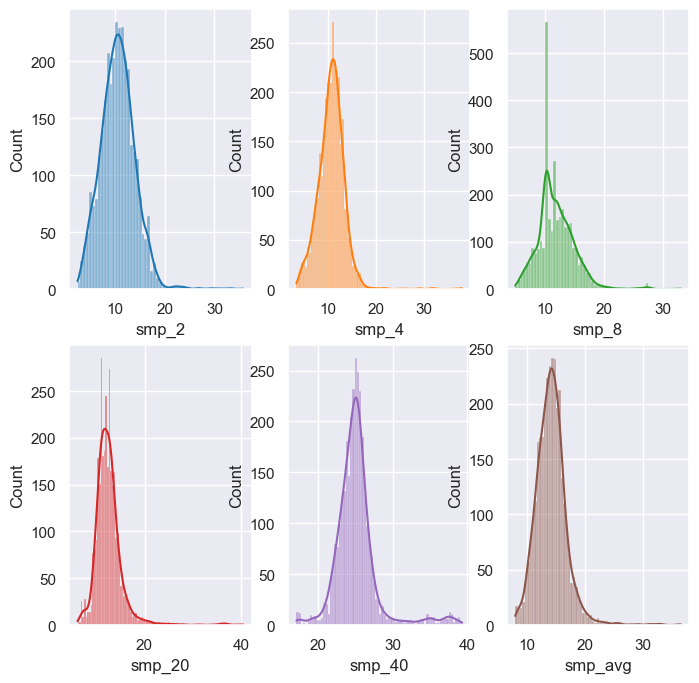

In [18]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 3, figsize=(8, 8))
sns.histplot(data=df, x='smp_2', kde=True, color=color_pal[0], ax=axs[0, 0])
sns.histplot(data=df, x='smp_4', kde=True, color=color_pal[1], ax=axs[0, 1])
sns.histplot(data=df, x='smp_8', kde=True, color=color_pal[2], ax=axs[0, 2])
sns.histplot(data=df, x='smp_20', kde=True, color=color_pal[3], ax=axs[1, 0])
sns.histplot(data=df, x='smp_40', kde=True, color=color_pal[4], ax=axs[1, 1])
sns.histplot(data=df, x='smp_avg', kde=True, color=color_pal[5], ax=axs[1, 2])
plt.show()

In [19]:
from sklearn.preprocessing import LabelEncoder

df = df.drop(['date'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3132 entries, 2008-11-01 to 2017-12-01
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   prcp_accum      3132 non-null   float64 
 1   air_temp_avg    3132 non-null   float64 
 2   smp_2           3132 non-null   float64 
 3   smp_4           3132 non-null   float64 
 4   smp_8           3132 non-null   float64 
 5   smp_20          3132 non-null   float64 
 6   smp_40          3132 non-null   float64 
 7   soil_temp_2     3132 non-null   float64 
 8   soil_temp_4     3132 non-null   float64 
 9   soil_temp_8     3132 non-null   float64 
 10  soil_temp_20    3132 non-null   float64 
 11  soil_temp_40    3132 non-null   float64 
 12  wind_dir_avg    3132 non-null   float64 
 13  wind_speed_avg  3132 non-null   float64 
 14  PRCP            3132 non-null   float64 
 15  year            3132 non-null   int64   
 16  month           3132 non-null   int64   
 

## Prepare for modeling ensemble

In [20]:

le = LabelEncoder()

df['season'] = le.fit_transform(df['season'])
df['weekday'] = le.fit_transform(df['weekday'])
df['day'] = le.fit_transform(df['day'])

In [21]:

train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

In [22]:
FEATURES = ['prcp_accum', 'air_temp_avg', 'smp_2', 'smp_4', 'smp_8', 'smp_20',
            'smp_40', 'soil_temp_2', 'soil_temp_4', 'soil_temp_8', 'soil_temp_20',
            'soil_temp_40', 'wind_dir_avg', 'wind_speed_avg', 'PRCP', 'year',
            'month', 'day', 'dayofweek', 'weekday', 'quarter', 'dayofyear',
            'dayofmonth', 'weekofyear', 'date_offset', 'season', 'soil_temp_avg',
            'smp_avg', 'lag1', 'lag2', 'lag3']
TARGET = 'SPI'

In [23]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


In [24]:
numeric_features = FEATURES[0:15] + FEATURES[26:28]
numeric_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='median'))])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ],
    remainder='passthrough',
)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['prcp_accum', 'air_temp_avg', 'smp_2',
                                  'smp_4', 'smp_8', 'smp_20', 'smp_40',
                                  'soil_temp_2', 'soil_temp_4', 'soil_temp_8',
                                  'soil_temp_20', 'soil_temp_40',
                                  'wind_dir_avg', 'wind_speed_avg', 'PRCP',
                                  'soil_temp_avg', 'smp_avg'])])

## Define Hyperopts - OBJ

In [25]:

from sklearn.model_selection import cross_val_score

evaluation = [(X_train, y_train), (X_test, y_test)]
def objective(args):
    pipe = Pipeline(steps=[
        ('model', args['model'])
    ])
    pipe.set_params(**args['params'])
    pipe.fit(X_train, y_train,  model__eval_set=evaluation,
            model__verbose=0, model__early_stopping_rounds=10)
    score = cross_val_score(pipe, preprocessor.fit_transform(X_train), y_train, cv=5, n_jobs=-1, error_score=0.99)
    return {'loss': 1 - np.median(score), 'status': STATUS_OK}


## Defining Hyperopts - Space

In [26]:
# Hyper Parameter Tuning

from sklearn.linear_model import LogisticRegression



space = hp.choice('classifiers', [
    {
        'model': xgb.XGBRegressor(),
        'params': {'model__max_depth': hp.choice("max_depth", [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]),
                   'model__gamma': hp.uniform('gamma', 1, 9),
                   'model__reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
                   'model__reg_lambda': hp.uniform('reg_lambda', 0, 1),
                   'model__colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                   'model__min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
                   'model__n_estimators': hp.choice('n_estimators', [80,100,200,300,400,500]),
                   'model__learning_rate': hp.choice('learning_rate', [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]),
                   'model__seed': 0,

                   }
    }

])



In [27]:
from hyperopt import space_eval

trials = Trials()

best_classifier = fmin(objective, space, algo=tpe.suggest,
                       max_evals=100, trials=trials)


best_params = space_eval(space, best_classifier)

100%|██████████| 100/100 [00:58<00:00,  1.70trial/s, best loss: 0.03491265111987185]


In [28]:
best_params['model']

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9668174256707895,
             enable_categorical=False, gamma=1.3565837784549726, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=6.0, missing=nan, monotone_constraints='()',
             n_estimators=80, n_jobs=12, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=98.0, reg_lambda=0.5957519041833805,
             scale_pos_weight=1, seed=0, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [50]:
import joblib
joblib.dump(best_params['model'], './Models/Tuned_Large_XGBoost.pkl')

['./Models/Tuned_Large_XGBoost.pkl']

In [29]:

from sklearn.metrics import r2_score


X_train_tf = preprocessor.fit_transform(X_train, y_train)
X_test_tf = preprocessor.transform(X_test)
evaluation_2 = [( X_train_tf, y_train), ( X_test_tf, y_test)]

model = best_params['model'].fit(X_train_tf, y_train, eval_set=evaluation_2, eval_metric='rmse', early_stopping_rounds=30, verbose=False)
y_pred = model.predict(X_train_tf)


# TRAIN -- classification report and store predictions/ probabilities
print('Training R^2 Report for estimator: ',
      str(model).split('(')[0])
score = r2_score(y_train, y_pred)
print("The accuracy of our model is {}%".format(round(score, 2) *100))

Training R^2 Report for estimator:  XGBRegressor
The accuracy of our model is 96.0%


In [30]:
X_test_tf = preprocessor.transform(X_test)

y_pred_test = model.predict(X_test_tf)

# TEST -- classification report and store predictions/ probabilities
print('Testing R^2 Report for estimator: ',
      str(model).split('(')[0])
score = r2_score(y_test, y_pred_test)
print("The accuracy of our model is {}%".format(round(score, 2) *100))

Testing R^2 Report for estimator:  XGBRegressor
The accuracy of our model is 96.0%


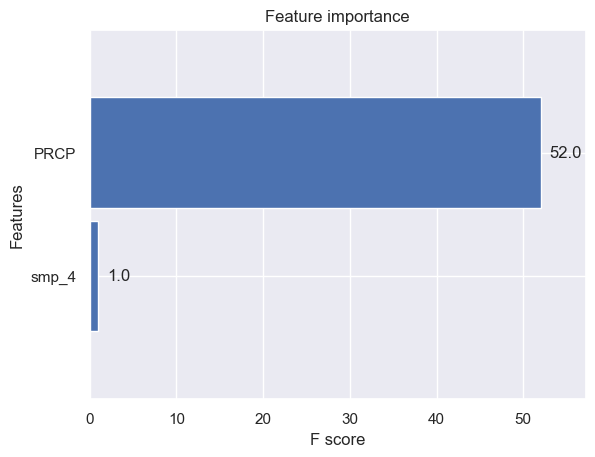

In [31]:
model.get_booster().feature_names = FEATURES

_ = plot_importance(model,height=0.9)

In [32]:
test['SPI_Prediction'] = model.predict(X_test_tf)
spi_all = pd.concat([train,test], sort = False)

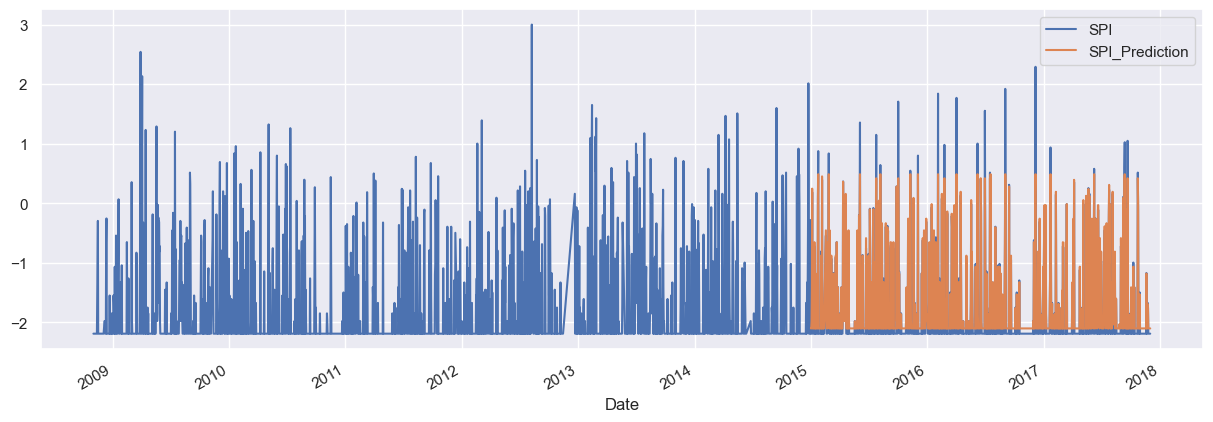

In [33]:


_ = spi_all[['SPI','SPI_Prediction']].plot(figsize=(15, 5))



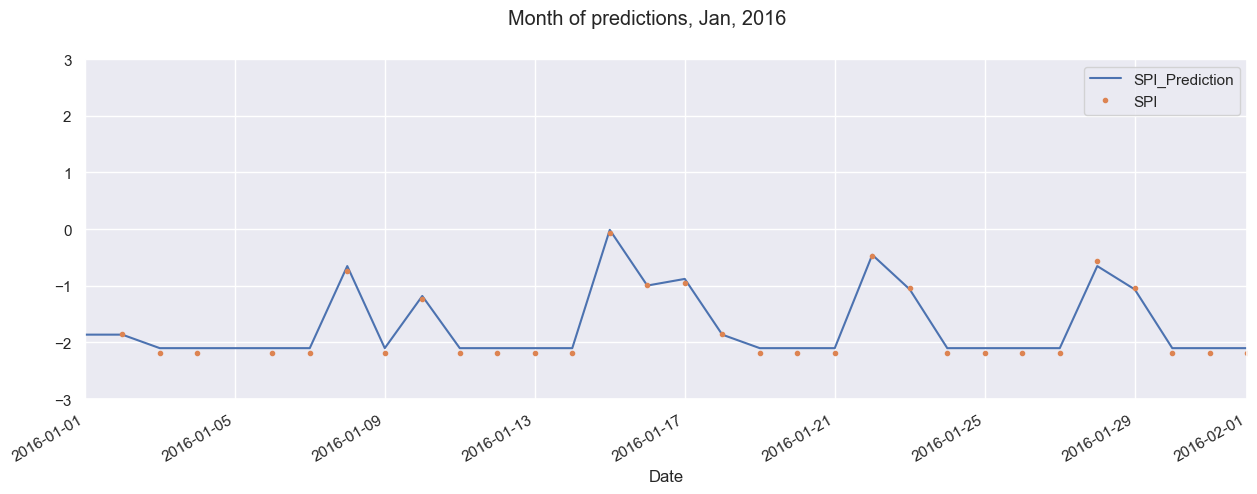

In [47]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = spi_all[['SPI_Prediction','SPI']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(-3, 3)
ax.set_xbound(lower='01-01-2016', upper='02-01-2016')
plot = plt.suptitle('Month of predictions, Jan, 2016')

In [35]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



def collect_error_metrics(data, true_col, pred_col):

    RMSE = mean_squared_error(y_true=data[true_col],y_pred=data[pred_col])
    MAE = mean_absolute_error(y_true=data[true_col], y_pred=data[pred_col])
    MAPE = mean_absolute_percentage_error(y_true=data[true_col], y_pred=data[pred_col])


    return RMSE, MAE, MAPE


RMSE, MAE, MAPE = collect_error_metrics(test, 'SPI','SPI_Prediction')

print('Our RMSE Error is', RMSE)
print('Our MAE Error is',MAE)
print('Our MAPE Error is', MAPE)


Our RMSE Error is 0.02061562299941938
Our MAE Error is 0.0857073441129644
Our MAPE Error is 7.31979470376419


In [36]:
SPI_test = test.copy()
SPI_test['error'] = SPI_test['SPI'] - SPI_test['SPI_Prediction']
SPI_test['abs_error'] = SPI_test['error'].apply(np.abs)
error_by_month = SPI_test.groupby(['year', 'month']).mean()[['SPI','SPI_Prediction','error','abs_error']]

In [37]:
# Worst Predicted year
error_by_month.sort_values('error', ascending=True).head(10)

SPI  SPI_Prediction     error  abs_error
year month                                               
2017 12    -2.190902       -2.102743 -0.088158   0.088158
2016 11    -2.182747       -2.098051 -0.084696   0.084839
2017 3     -2.012290       -1.930919 -0.081371   0.081965
     8     -1.866382       -1.786391 -0.079991   0.080881
     4     -1.973193       -1.893594 -0.079599   0.079722
     7     -1.553576       -1.474000 -0.079576   0.083314
2015 5     -2.097822       -2.019457 -0.078365   0.078605
2016 10    -2.125573       -2.048240 -0.077333   0.081920
     5     -1.936584       -1.864129 -0.072455   0.076962
     3     -1.821059       -1.748791 -0.072269   0.080152

In [38]:
# Worst absolute Predicted Months
error_by_month.sort_values('abs_error', ascending=False).head(10)

SPI  SPI_Prediction     error  abs_error
year month                                               
2016 2     -1.776941       -1.779812  0.002871   0.136007
     12    -1.688085       -1.680107 -0.007978   0.130400
     9     -1.786271       -1.759685 -0.026586   0.125070
     6     -1.687490       -1.678677 -0.008813   0.122944
2017 9     -1.622989       -1.602876 -0.020113   0.114150
2016 4     -1.776686       -1.760103 -0.016583   0.111357
2015 10    -1.851917       -1.836098 -0.015818   0.105486
     7     -1.614187       -1.581857 -0.032330   0.096370
     6     -1.642323       -1.615021 -0.027302   0.088367
2017 12    -2.190902       -2.102743 -0.088158   0.088158

In [39]:
# Best Predicted Months
error_by_month.sort_values('abs_error', ascending=True).head(10)

SPI  SPI_Prediction     error  abs_error
year month                                               
2015 4     -1.657189       -1.610422 -0.046767   0.055550
     3     -1.868583       -1.812281 -0.056302   0.062497
2016 8     -1.844842       -1.789369 -0.055472   0.063436
2015 11    -1.711373       -1.662036 -0.049337   0.063678
     9     -1.789115       -1.725752 -0.063363   0.068497
2016 1     -1.733242       -1.674128 -0.059114   0.069994
2017 2     -2.012214       -1.943468 -0.068747   0.072937
     5     -1.828804       -1.759969 -0.068836   0.073587
     11    -2.080655       -2.011672 -0.068983   0.073750
2015 12    -1.747045       -1.694971 -0.052075   0.075951

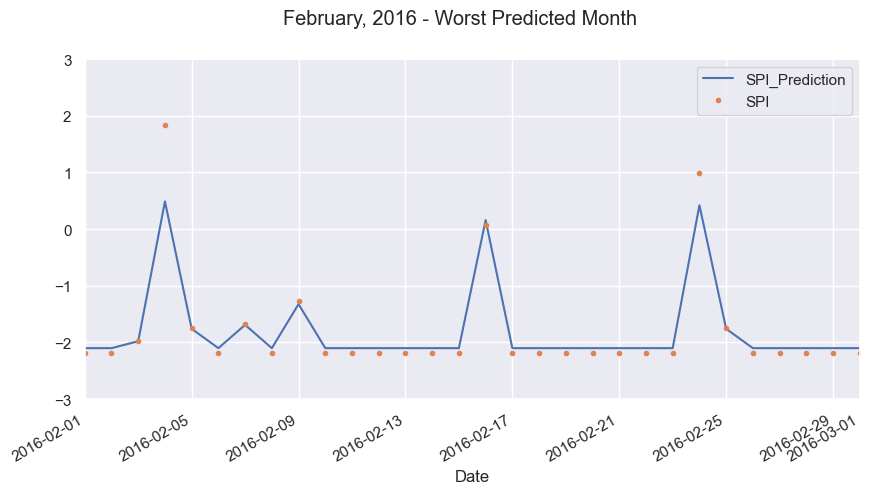

In [43]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = spi_all[['SPI_Prediction','SPI']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(-3, 3)
ax.set_xbound(lower='02-01-2016', upper='03-01-2016')
plot = plt.suptitle('February, 2016 - Worst Predicted Month')

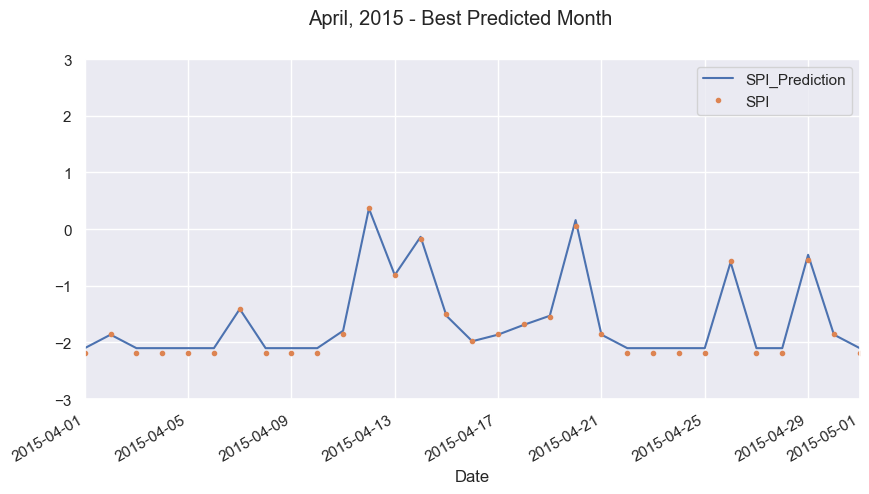

In [44]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = spi_all[['SPI_Prediction','SPI']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(-3, 3)
ax.set_xbound(lower='04-01-2015', upper='05-01-2015')
plot = plt.suptitle('April, 2015 - Best Predicted Month')